In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

In [ ]:
def augment(x):
      
    # flip
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)

    # color
    x = tf.image.random_hue(x, 0.08)
    x = tf.image.random_saturation(x, 0.6, 1.6)
    x = tf.image.random_brightness(x, 0.05)
    x = tf.image.random_contrast(x, 0.7, 1.3)  

    # crop
    x = tf.image.random_crop(x, [32, 32, 3])

    return x

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incomplete2WQNPM/cifar10-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incomplete2WQNPM/cifar10-test.tfrecord*...:   0%|          | 0/1…

Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


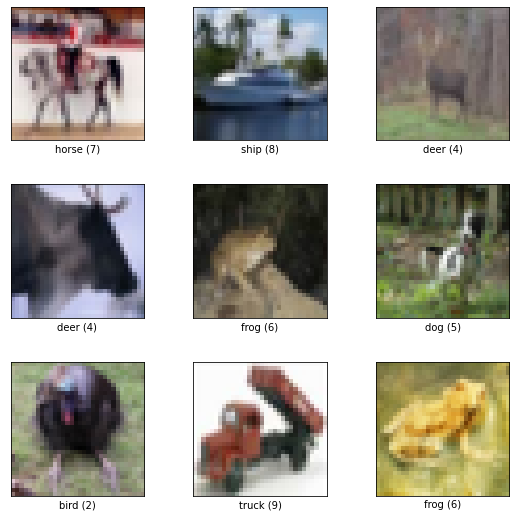

In [ ]:
# load the data
(train_ds, val_ds), ds_info = tfds.load('cifar10', split=['train', 'test'], 
                            shuffle_files=True, with_info=True)
# visualize a sample
#print(ds_info)
tfds.show_examples(train_ds, ds_info)


# preprocess the data 
one_hot = lambda x: tf.one_hot(x, 10)
map_func = lambda x, y: (tf.cast(x, dtype=tf.float32)/255., # normalization
                            tf.cast(one_hot(y),tf.float32)) # make labels into one hot vectors
map_func_2 = lambda x: (x["image"],x["label"])
train_ds = train_ds.map(map_func_2).map(map_func)
val_ds   = val_ds.map(map_func_2).map(map_func).cache()

# augment data
train_ds = train_ds.map(lambda x, y: (augment(x), y))
#train_ds = train_ds.concatenate(aug_train).cache()

# prepare the datasets
batch_size = 64
train_ds = train_ds.shuffle(4096).batch(batch_size)
val_ds   = val_ds.shuffle(4096).batch(batch_size)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
# Model with no regularization, only the convolutional/dense layer & pooling
# 3 convolutional hidden layers + 1 fully connected hidden layer + ouput layer
class BlankModel(tf.keras.Model):
  
    def __init__(self):
        super().__init__()
        
        self.layer1 = tf.keras.Sequential()
        self.layer1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu'))                    
        self.layer1.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))

        self.layer2 = tf.keras.Sequential()
        self.layer2.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
        self.layer2.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
      
        self.layer3 = tf.keras.Sequential()
        self.layer3.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
        self.layer3.add(tf.keras.layers.GlobalMaxPooling2D())

        self.layer4 = tf.keras.Sequential()
        self.layer4.add(tf.keras.layers.Dense(64, activation='relu'))
        
        self.out = tf.keras.layers.Dense(10, activation='softmax')

    @tf.function
    def call(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x) 
        x = self.out(x)
        return x

In [ ]:
# model with regualarization and optimization
# 3 convolutional hidden layers + 1 fully connected hidden layer + ouput layer
class RegulOptimModel(tf.keras.Model):
   
    def __init__(self):
        super().__init__()

        #kernel_regularizer = tf.keras.regularizers.L2(0.001)

        self.layer1 = tf.keras.Sequential()
        self.layer1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu'))#, 
                                               #kernel_regularizer=kernel_regularizer, kernel_initializer='he_uniform'))
        self.layer1.add(tf.keras.layers.BatchNormalization())
        self.layer1.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))

        self.layer2 = tf.keras.Sequential()
        self.layer2.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))#, 
                                               #kernel_regularizer=kernel_regularizer, kernel_initializer='he_uniform'))
        self.layer2.add(tf.keras.layers.BatchNormalization())
        self.layer2.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
        self.layer2.add(tf.keras.layers.Dropout(0.2))
      
        self.layer3 = tf.keras.Sequential()
        self.layer3.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))#, 
                                               #kernel_regularizer=kernel_regularizer, kernel_initializer='he_uniform'))
        self.layer3.add(tf.keras.layers.BatchNormalization())
        self.layer3.add(tf.keras.layers.GlobalMaxPooling2D())
        self.layer3.add(tf.keras.layers.Dropout(0.2))

        self.layer4 = tf.keras.Sequential()
        self.layer4.add(tf.keras.layers.Dense(64, activation='relu'))
        self.layer4.add(tf.keras.layers.BatchNormalization())
        self.layer4.add(tf.keras.layers.Dropout(0.3))
        
        self.out = tf.keras.layers.Dense(10, activation='softmax')

    @tf.function
    def call(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x) 
        x = self.out(x)
        return x

In [ ]:
import pprint
import tqdm
import matplotlib.pyplot as plt

def training_loop(model, train_ds, val_ds, epochs):
      
    # create arrays for plot visualization of metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []   

    for epoch in range(epochs):
        print(f"Epoch {epoch}:")
        
        # Training:
        for data in tqdm.tqdm(train_ds, position=0, leave=True):
            metrics = model.train_step(data)
            
        train_losses.append(metrics["loss"])
        train_accuracies.append(metrics["accuracy"])

        print([f"train_{key}: {value.numpy()}" for (key, value) in metrics.items()])
        model.reset_metrics()    
        
        # Validation:
        for data in val_ds:
            metrics = model.test_step(data)
        
        val_losses.append(metrics["loss"])
        val_accuracies.append(metrics["accuracy"])
                    
        print([f"val_{key}: {value.numpy()}" for (key, value) in metrics.items()])
        print()
        model.reset_metrics()

    # Visualize accuracy and loss for training and test data
    plt.figure()
    line1, = plt.plot(train_losses)
    line2, = plt.plot(val_losses)
    line3, = plt.plot(val_accuracies)
    line4, = plt.plot(train_accuracies)
    plt.xlabel("Training steps")
    plt.ylabel("Loss/Accuracy")
    plt.legend((line1, line4, line2, line3),("train loss", "train accuracy", "val loss", "val accuracy"))
    plt.show()

Model: "regul_optim_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 16, 16, 32)        2560      
                                                                 
 sequential_1 (Sequential)   (None, 8, 8, 64)          18752     
                                                                 
 sequential_2 (Sequential)   (None, 128)               74368     
                                                                 
 sequential_3 (Sequential)   (None, 64)                8512      
                                                                 
 dense_1 (Dense)             multiple                  650       
                                                                 
Total params: 104,842
Trainable params: 104,266
Non-trainable params: 576
_________________________________________________________________
Epoch 0:


100%|██████████| 782/782 [02:55<00:00,  4.45it/s]


['train_loss: 1.8791215419769287', 'train_accuracy: 0.35249999165534973']
['val_loss: 1.6390998363494873', 'val_accuracy: 0.46959999203681946']

Epoch 1:


100%|██████████| 782/782 [03:21<00:00,  3.87it/s]


['train_loss: 1.6057895421981812', 'train_accuracy: 0.49869999289512634']
['val_loss: 1.515987753868103', 'val_accuracy: 0.5403000116348267']

Epoch 2:


100%|██████████| 782/782 [03:21<00:00,  3.87it/s]


['train_loss: 1.4936854839324951', 'train_accuracy: 0.551859974861145']
['val_loss: 1.4187862873077393', 'val_accuracy: 0.5870000123977661']

Epoch 3:


100%|██████████| 782/782 [03:21<00:00,  3.87it/s]


['train_loss: 1.4262956380844116', 'train_accuracy: 0.5851399898529053']
['val_loss: 1.3555659055709839', 'val_accuracy: 0.6207000017166138']

Epoch 4:


100%|██████████| 782/782 [02:43<00:00,  4.79it/s]


['train_loss: 1.3704614639282227', 'train_accuracy: 0.6144400238990784']
['val_loss: 1.3211302757263184', 'val_accuracy: 0.6362000107765198']

Epoch 5:


100%|██████████| 782/782 [02:43<00:00,  4.78it/s]


['train_loss: 1.3239915370941162', 'train_accuracy: 0.6390799880027771']
['val_loss: 1.3407390117645264', 'val_accuracy: 0.6251999735832214']

Epoch 6:


100%|██████████| 782/782 [02:41<00:00,  4.85it/s]


['train_loss: 1.2998102903366089', 'train_accuracy: 0.6479200124740601']
['val_loss: 1.282556176185608', 'val_accuracy: 0.6571999788284302']

Epoch 7:


100%|██████████| 782/782 [03:21<00:00,  3.87it/s]


['train_loss: 1.2723838090896606', 'train_accuracy: 0.6624799966812134']
['val_loss: 1.2971045970916748', 'val_accuracy: 0.6488999724388123']

Epoch 8:


100%|██████████| 782/782 [03:21<00:00,  3.87it/s]


['train_loss: 1.2489721775054932', 'train_accuracy: 0.6719200015068054']
['val_loss: 1.2364075183868408', 'val_accuracy: 0.6825000047683716']

Epoch 9:


100%|██████████| 782/782 [03:21<00:00,  3.87it/s]


['train_loss: 1.2286115884780884', 'train_accuracy: 0.6842600107192993']
['val_loss: 1.2181074619293213', 'val_accuracy: 0.694100022315979']

Epoch 10:


100%|██████████| 782/782 [02:43<00:00,  4.80it/s]


['train_loss: 1.2136459350585938', 'train_accuracy: 0.6934000253677368']
['val_loss: 1.2486439943313599', 'val_accuracy: 0.67330002784729']

Epoch 11:


100%|██████████| 782/782 [03:21<00:00,  3.87it/s]


['train_loss: 1.1986846923828125', 'train_accuracy: 0.6990600228309631']
['val_loss: 1.2375731468200684', 'val_accuracy: 0.6812999844551086']

Epoch 12:


100%|██████████| 782/782 [02:44<00:00,  4.77it/s]


['train_loss: 1.1816089153289795', 'train_accuracy: 0.7061600089073181']
['val_loss: 1.204380750656128', 'val_accuracy: 0.6945000290870667']

Epoch 13:


100%|██████████| 782/782 [03:21<00:00,  3.87it/s]


['train_loss: 1.1700268983840942', 'train_accuracy: 0.7133600115776062']
['val_loss: 1.1866227388381958', 'val_accuracy: 0.7021999955177307']

Epoch 14:


100%|██████████| 782/782 [02:42<00:00,  4.80it/s]


['train_loss: 1.1563410758972168', 'train_accuracy: 0.7167199850082397']
['val_loss: 1.16110360622406', 'val_accuracy: 0.7206000089645386']

Epoch 15:


100%|██████████| 782/782 [03:21<00:00,  3.87it/s]


['train_loss: 1.143554925918579', 'train_accuracy: 0.7250400185585022']
['val_loss: 1.1872044801712036', 'val_accuracy: 0.7027000188827515']

Epoch 16:


100%|██████████| 782/782 [03:21<00:00,  3.87it/s]


['train_loss: 1.1368986368179321', 'train_accuracy: 0.7270399928092957']
['val_loss: 1.1839569807052612', 'val_accuracy: 0.704200029373169']

Epoch 17:


100%|██████████| 782/782 [03:21<00:00,  3.87it/s]


['train_loss: 1.1207062005996704', 'train_accuracy: 0.7348399758338928']
['val_loss: 1.1613386869430542', 'val_accuracy: 0.7192999720573425']

Epoch 18:


100%|██████████| 782/782 [03:21<00:00,  3.87it/s]


['train_loss: 1.116883397102356', 'train_accuracy: 0.7374799847602844']
['val_loss: 1.1526581048965454', 'val_accuracy: 0.7202000021934509']

Epoch 19:


100%|██████████| 782/782 [03:21<00:00,  3.87it/s]


['train_loss: 1.107804775238037', 'train_accuracy: 0.7409399747848511']
['val_loss: 1.162940502166748', 'val_accuracy: 0.7178999781608582']



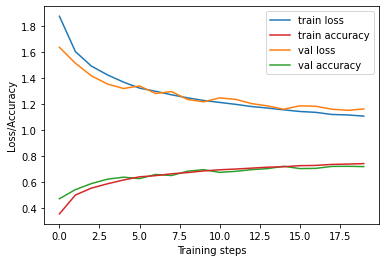

In [ ]:
# instantiate and compile model with its hyperparameters
#model = BlankModel()
model = RegulOptimModel()
model.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), metrics=["accuracy"])

# build the model and show summary
model(tf.keras.Input((32,32,3)));
model.summary()

# run the training loop 
training_loop(model=model, 
              train_ds=train_ds, 
              val_ds=val_ds, 
              epochs=20
)

#Optimization and Regularization

Starting with the **"blank" model**, a batch size of 64 and 20 epochs training, we first tested a few different combinations of numbers of filters (convolutional) or units (dense) for the hidden layers:
- 32, 64, 128 (conv) + 128 (dense)
- 64, 128, 64 + 128
- 64, 128, 256 + 128
- 32, 64, 128 + 64 

Since the first and the last had the best performance but the last one fewer model parameters (102,154), we proceeded with this one. The big gap between the train loss and validation loss (Graph A) shows that the model is significantly overfitting the data.

Final Performance: (**A**)
- loss: 0.1737 - Accuracy: 0.9373
- val_loss: 1.3734 - val_accuracy: 0.722

Next we added **Batch Normalization**
layers after each hidden layer. This regularized and otimized the performance a little bit.

Performance: (**B**)
- loss: 0.2346 - accuracy: 0.9168 
- val_loss: 1.0732 - val_accuracy: 0.7304

Next we added **Dropout** layers. This  helped with the Overfitting problem immensely. The gap between training and validation loss (Graph C) got almost completely closed.

Performance: (**C**)
- loss: 0.2346 - accuracy: 0.9168 
- val_loss: 1.0732 - val_accuracy: 0.7304

Next we added **Label Smoothing** which made the validation graphs a bit more stable (Graph D).

Performance: (**D**)
- loss: 1.0228 - accuracy: 0.7913 
- val_loss: 1.0329 - val_accuracy: 0.7748

Next we tried out adding a **Kernel Regularizer** and also a different **Kernel Initializer** to the convolutional hidden layers but that only made the performance worse or didn't change much so we dropped two additions again.

Lastly, we tried to implement **Data Augementation**. In this Notebook, we change the training dataset with a selfmade augmentation function and either use that as the new training data or expand the 'not-changed' training data set by this altered version to get a larger training set. As expected, for the second version with both datasets concatenated, the training loss and accuracy improved a lot, but the gap between training and validation loss got lager. The validation performances were almost exactly the same.

Performance with only Augmentation: (**E**)
- loss: 1.1232813596725464 - accuracy: 0.735159993171691
- val_loss: 1.209443211555481 - val_accuracy: 0.6891000270843506

Performance with Concatenation: (**F**)
- loss: 0.8384793996810913 - accuracy: 0.8756600022315979'
- val_loss: 1.2801645994186401 - val_accuracy: 0.6866999864578247


In another notebook (Homework06_alternative), where we use a ImageDataGenerator (and also the "forbidden" model.fit() function) to perform a data augmentation. We tried out two different settings of the ImageDataGenerator which performed very similarly but the first one was slightly better. Both performed better than the self-made augment function from the other notebook.

Performance: (**G**)
- loss: 1.0198 - accuracy: 0.7911 
- val_loss: 1.0641 - val_accuracy: 0.7618


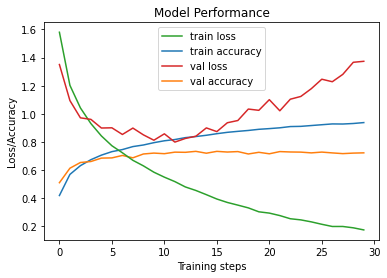

Graph A (blank model)

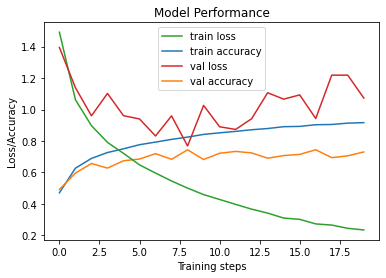

Graph B (batch normalization)

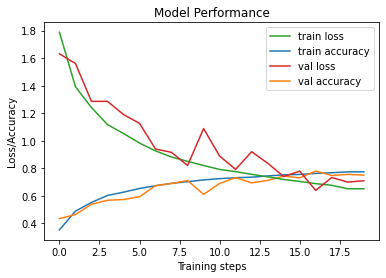

Graph C (Dropout)

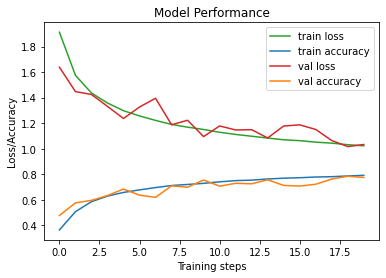

Graph D (Label Smoothing)

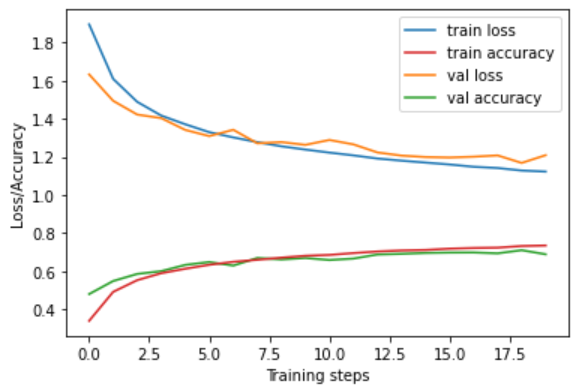

Graph E (Data Augmentation)

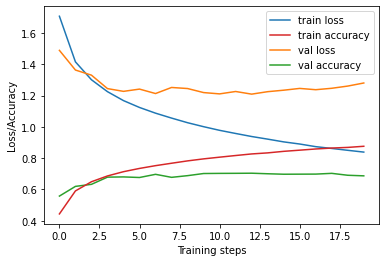

Graph F (Data Augmentation with Concatenate)

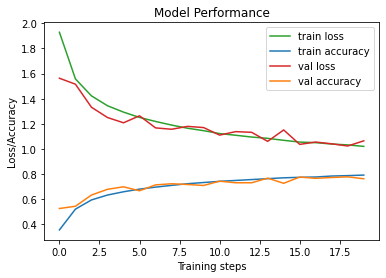

Graph G (Data Augmentation with ImageDataGenerator)